# Aries Basic Controller - Sovrin Stagingnet Issuer Agent

## This notebook walks through how to issue a credential across a newly established connection with a mobile SSI agent. It should be run in parallel with the [Verifier notebook](http://127.0.0.1:8889/notebooks/Part%203%20-%20Verifier.ipynb) controlling the agent that will verify the credential.

## Before running through this notebook you should run through the Getting Started notebooks - [Getting Started](http://127.0.0.1:8888/notebooks/Part%201%20-%20Getting%20Started.ipynb).

If unfamiliar with the protocol it is worth reading through the [aries-rfs](https://github.com/hyperledger/aries-rfcs/tree/master/features/0036-issue-credential)


## 1. Initialise a controller for Issuer

In [1]:
%autoawait
import time
import asyncio
from aries_basic_controller.aries_controller import AriesAgentController
    
WEBHOOK_HOST = "0.0.0.0"
WEBHOOK_PORT = 8022
WEBHOOK_BASE = ""
ADMIN_URL = "http://issuer-agent:8021"

# Based on the aca-py agent you wish to control
agent_controller = AriesAgentController(webhook_host=WEBHOOK_HOST, webhook_port=WEBHOOK_PORT,
                                       webhook_base=WEBHOOK_BASE, admin_url=ADMIN_URL)
    

IPython autoawait is `on`, and set to use `asyncio`


## 2. Register Listeners

The handler should get called every time the controller receives a webhook with the topic issue_credential, printing out the payload. The agent calls to this webhook every time it receives an issue-credential protocol message from a credential.

In [2]:
loop = asyncio.get_event_loop()
loop.create_task(agent_controller.listen_webhooks())

def cred_handler(payload):
    print("Handle Credentials")
    exchange_id = payload['credential_exchange_id']
    state = payload['state']
    role = payload['role']
    attributes = payload['credential_proposal_dict']['credential_proposal']['attributes']
    print(f"Credential exchange {exchange_id}, role: {role}, state: {state}")
    print(f"Offering: {attributes}")
    
cred_listener = {
    "topic": "issue_credential",
    "handler": cred_handler
}

def messages_handler(payload):
    connection_id = payload["connection_id"]
    asyncio.get_event_loop().create_task(agent_controller.messaging.send_message(connection_id, "This is a response from Bob"))
    print("Handle message", payload, connection_id)


message_listener = {
    "handler": messages_handler,
    "topic": "basicmessages"
}

def connections_handler(payload):
    global STATE
    connection_id = payload["connection_id"]
    print("Connection message", payload, connection_id)
    STATE = payload['state']
    if STATE == 'active':
        print('Connection {0} changed state to active'.format(connection_id))


connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

def proof_handler(payload):
    print("Handle present proof")
    print(payload)

proof_listener = {
    "topic": "present_proof",
    "handler": proof_handler
}

agent_controller.register_listeners([cred_listener,message_listener,connection_listener,proof_listener], defaults=True)



## 3a. Use a previously written schema

In [3]:
schema_id = 'MGgoJXWbeupKsaHDa7s4fW:2:testabc:0.0.1'

## 3b. (OPTIONAL) Write a Schema to the Ledger

For more details see the [schema-api notebook](http://localhost:8888/notebooks/schema_api.ipynb)

**Note: You will only be able to do this once unless you change the schema_name or version. Once you have a schema written to the ledger it can be reused by multiple entities**

In [4]:
# Define you schema name - must be unique on the ledger
schema_name = "testabc"
# Can version the schema if you wish to update it
schema_version = "0.0.1"
# Define any list of attributes you wish to include in your schema
attributes = ["name", "skill", "age"]

response = await agent_controller.schema.write_schema(schema_name, attributes, schema_version)
schema_id = response["schema_id"]
print(schema_id)


PQRXDxdGqQGSZ8z69p4xZP:2:testabc:0.0.1


## 4. Write a Credential Definition to the Ledger

More details in the [definitions notebook](http://localhost:8888/notebooks/definitions_api.ipynb)

**Note: Again this can only be done once per issuer, per schema_id.**

In [4]:
response = await agent_controller.definitions.write_cred_def(schema_id)

cred_def_id = response["credential_definition_id"]
print(cred_def_id)

T8dV2Hqgiqht3kptui4uhE:3:CL:141433:default


**Note: You should be able to see both schema and definition transactions on Sovrin Stagingnet network with [Indyscan](https://indyscan.io/home/SOVRIN_STAGINGNET)**

## 6. Populate the Attribues to Issue to Idenity Holder (User)

The schema defines two attributes: name and skill. Both must be populated with attribute values that the Issuer wishes to issue in a credential to a User. To do this a list of objects must be created, each object containing the name of the attribute and it's value at a minimum. You can set the values to anything you wish.

TODO: Some additional fields such as mime-type can be defined.

In [5]:
credential_attributes = [
    {"name": "name", "value": "Bob"},
    {"name": "skill", "value": "researcher"},
    {"name": "age", "value": "21"}
]
print(credential_attributes)

[{'name': 'name', 'value': 'Bob'}, {'name': 'skill', 'value': 'researcher'}, {'name': 'age', 'value': '21'}]


## 7. Download Identity Holder Mobile SSI Wallet
Please download a mobile SSI wallet such as [Connect.me](https://connect.me/), [Trinsic](https://trinsic.id/trinsic-wallet/) or any other Aries compatible wallet.

## 8. Create a connection invitation to scan with the Mobile SSI Wallet

In [6]:
!pip install pillow
!pip install qrcode

## 8a. Check for any existing connections

In [7]:
# Check for existing connections
connection = await agent_controller.connections.get_connections()
print("EXISTING CONNECTIONS")
for key, value in connection.items():
    for item in value:
        print('ConnectionID:', item['connection_id'], 'Status:',item['state'])

EXISTING CONNECTIONS
ConnectionID: 9d00223e-4a1c-45d1-97e8-d8d174c0a888 Status: active
ConnectionID: bc5465ae-7194-41e4-9b73-adf3c43af5cc Status: active
ConnectionID: d93f05ca-2b62-4e59-a344-91f1fa131a6c Status: active
ConnectionID: 192484ac-a26d-471c-ace6-bb5c6634ee7c Status: active
ConnectionID: 54859a50-7702-4e04-bea4-ace286fc89f1 Status: active
ConnectionID: 2621b543-3fb6-4195-8e36-624226de79aa Status: active
ConnectionID: 3e019a71-0d6c-4206-be3a-e2e015275ca9 Status: response
ConnectionID: 16ceb06f-a886-4353-831f-573d2cfcd357 Status: active
ConnectionID: a8912313-a454-40d4-9b4c-0159dfa88c72 Status: invitation


## 8b. Create an Invitation

In [8]:
# Create Invitation
invite = await agent_controller.connections.create_invitation()
connection_id = invite["connection_id"]
print("Connection ID", connection_id)
print("Invitation")
print(invite['invitation_url'])
inviteURL = invite['invitation_url']

Connection message {'invitation_key': 'fB5Ys8bMcgq6gmznhQEAaCo1waSTkQ9L2ud4a25AaGX', 'initiator': 'self', 'invitation_mode': 'once', 'updated_at': '2020-09-15 10:20:23.004351Z', 'accept': 'auto', 'connection_id': 'f88366ac-8f49-48fd-a428-2d722892d58f', 'routing_state': 'none', 'created_at': '2020-09-15 10:20:23.004351Z', 'state': 'invitation'} f88366ac-8f49-48fd-a428-2d722892d58f
Connection ID f88366ac-8f49-48fd-a428-2d722892d58f
Invitation
https://edc18ada8b3f.ngrok.io?c_i=eyJAdHlwZSI6ICJkaWQ6c292OkJ6Q2JzTlloTXJqSGlxWkRUVUFTSGc7c3BlYy9jb25uZWN0aW9ucy8xLjAvaW52aXRhdGlvbiIsICJAaWQiOiAiOGYwODU0ZWQtNzE0Zi00ZDkzLTkzMTItODkzMzQ3OTBmZmZmIiwgInNlcnZpY2VFbmRwb2ludCI6ICJodHRwczovL2VkYzE4YWRhOGIzZi5uZ3Jvay5pbyIsICJsYWJlbCI6ICJJc3N1ZXIiLCAicmVjaXBpZW50S2V5cyI6IFsiZkI1WXM4Yk1jZ3E2Z216bmhRRUFhQ28xd2FTVGtROUwydWQ0YTI1QWFHWCJdfQ==


## 8c. Generate QR Code to be scanned with Mobile SSI Wallet

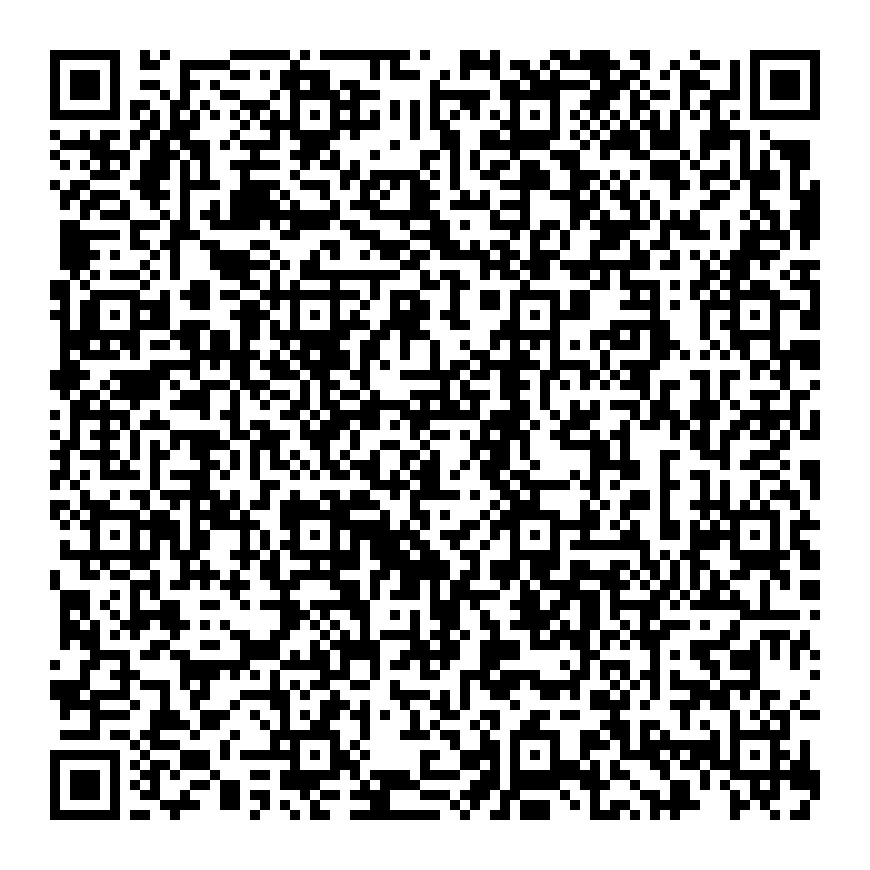

Connection message {'their_label': 'some-random-name', 'invitation_key': 'fB5Ys8bMcgq6gmznhQEAaCo1waSTkQ9L2ud4a25AaGX', 'initiator': 'self', 'invitation_mode': 'once', 'updated_at': '2020-09-15 10:20:33.814793Z', 'accept': 'auto', 'connection_id': 'f88366ac-8f49-48fd-a428-2d722892d58f', 'their_did': 'DXQPbopXdw57ZYAgdFKsNZ', 'routing_state': 'none', 'created_at': '2020-09-15 10:20:23.004351Z', 'state': 'request'} f88366ac-8f49-48fd-a428-2d722892d58f
Connection message {'my_did': 'NDmFjYQGF39rKGzMosBCUg', 'their_label': 'some-random-name', 'invitation_key': 'fB5Ys8bMcgq6gmznhQEAaCo1waSTkQ9L2ud4a25AaGX', 'initiator': 'self', 'invitation_mode': 'once', 'updated_at': '2020-09-15 10:20:33.842832Z', 'accept': 'auto', 'connection_id': 'f88366ac-8f49-48fd-a428-2d722892d58f', 'their_did': 'DXQPbopXdw57ZYAgdFKsNZ', 'routing_state': 'none', 'created_at': '2020-09-15 10:20:23.004351Z', 'state': 'response'} f88366ac-8f49-48fd-a428-2d722892d58f


In [9]:
import qrcode
# Link for connection invitation
input_data = inviteURL
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=10,
        border=5)
qr.add_data(input_data)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img.save('issuer_agent_invite_QRcode.png')

from IPython.display import Image
Image(width=400, filename='./issuer_agent_invite_QRcode.png')

## 8d. Send Trust Ping to ensure connection is in active state

In [10]:
trust_ping = await agent_controller.messaging.trust_ping(connection_id,'hello')
print(trust_ping)

{'thread_id': '328464cb-b676-474f-8cfa-b6e44a41a9e1'}


## 8e. Check if established connection is in active state

In [12]:
import time
# Check for existing connections
# connection = await agent_controller.connections.get_connections()
# print("EXISTING CONNECTIONS")
# for key, value in connection.items():
#     for item in value:
#         print('ConnectionID:', item['connection_id'], 'Status:',item['state'])
#         if item['connection_id'] == connection_id:
#             while item['state'] != 'active':
#                 #connection_id = item['connection_id']
#                 print('Connection: {0} not in active state yet'.format(item['connection_id']))
#                 trust_ping = await agent_controller.messaging.trust_ping(connection_id,'hello!')
#                 print('Trust ping send to {0} to sactivate connection'.format(trust_ping))
#                 time.sleep(5)

print('Current state for ConnectionId {} is {}'.format(connection_id,STATE))
while STATE != 'active':
    print('ConnectionId {0} is not in active state yet'.format(connection_id))
#     trust_ping = await agent_controller.messaging.trust_ping(connection_id,'hello!')
#     print('Trust ping send to ConnectionId {0} to activate connection'.format(trust_ping))
    time.sleep(10)
    
print('ConnectionId: {0} is now active. Continue with notebook'.format(connection_id))


Current state for ConnectionId f88366ac-8f49-48fd-a428-2d722892d58f is active
ConnectionId: f88366ac-8f49-48fd-a428-2d722892d58f is now active. Continue with notebook


## 9. Send Credential

This sends a credential to a identity holder (User), and automates the rest of the protocol.

There are other ways to issue a credential that require multiple api calls.

**Arguments**
* connection_id: The connection_id of the holder you wish to issue to (MUST be in active state)
* schema_id: The id of the schema you wish to issue
* cred_def_id: The definition (public key) to sign the credential object. This must refer to the schema_id and be written to the ledger by the same public did that is currently being used by the agent.
* attributes: A list of attribute objects as defined above. Must match the schema attributes.
* comment (optional): Any string, defaults to ""
* auto_remove (optional): Boolean, defaults to True. I believe this removes the record of this credential once it has been issued. (TODO: double check)
* trace (optional): Boolean, defaults to False. **Not entirely sure about this one, believe its for logging. Also when set to True it throws an error**

In [7]:
record = await agent_controller.issuer.send_credential(connection_id, schema_id, cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")


{'issuer_did': 'PQRXDxdGqQGSZ8z69p4xZP', 'auto_remove': True, 'credential_proposal': {'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/issue-credential/1.0/credential-preview', 'attributes': [{'name': 'name', 'value': 'Bob'}, {'name': 'skill', 'value': 'researcher'}, {'name': 'age', 'value': '21'}]}, 'connection_id': '4a3bfb5d-483c-4ba3-b7f8-3755d09a3fb9', 'trace': False, 'comment': '', 'cred_def_id': 'PQRXDxdGqQGSZ8z69p4xZP:3:CL:10:default', 'schema_id': 'PQRXDxdGqQGSZ8z69p4xZP:2:open_mined_contributor:0.0.1', 'schema_name': 'open_mined_contributor', 'schema_version': '0.0.1', 'schema_issuer_did': 'PQRXDxdGqQGSZ8z69p4xZP'}
Credential exchange 1a7aca80-0d1b-4232-9888-1f270a9f3886, role: issuer, state: offer_sent
Handle Credentials
Credential exchange 1a7aca80-0d1b-4232-9888-1f270a9f3886, role: issuer, state: offer_sent
Being offered: [{'name': 'name', 'value': 'Bob'}, {'name': 'skill', 'value': 'researcher'}, {'name': 'age', 'value': '21'}]
Handle Credentials
Credential exchange 1a7aca80-

## 10. Continue on Verifier Notebook

Continue to the [Verifier Notebook](http://127.0.0.1:8889/notebooks/Part%203%20-%20Verifier.ipynb)

It works best if this notebook is already initialised and has listeners registered.

## End of Tutorial

Be sure to terminate the controller so you can run another tutorial.

In [13]:
response = await agent_controller.terminate()
print(response)

None
